This notebook groups the orbits into general categories.

# Satellite Orbits
The data used in this analysis Joint Spectrum Center Equipment, Tactical, Space (JETS) database. The complete data set contained 55 data fields and 9539 satellite records. The majority of the records did not contain orbital parameter data, were duplicates, or were labeled as "dummy" or "filler data". The data set was cleaned to remove those records as well as all CUI data. 

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
import pydot
from IPython.display import Image

sns.set_theme(style='darkgrid')

The goal of this project is to predict the Orbit Type from other satellite data. 

Load data  

In [2]:
df = pd.read_csv('satellites.csv',index_col='Index')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1024 entries, 22 to 9533
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Inclination Angle (deg)                  1024 non-null   float64
 1   Right Ascension of Ascending Node (deg)  1024 non-null   float64
 2   Eccentricity                             1024 non-null   float64
 3   Argument of Perigee (deg)                1024 non-null   float64
 4   Mean Anomaly (deg)                       1024 non-null   float64
 5   Mean Motion (revs/day)                   1024 non-null   float64
 6   Orbit Type                               1024 non-null   object 
dtypes: float64(6), object(1)
memory usage: 64.0+ KB


In [3]:
df.describe(include='all').transpose()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Inclination Angle (deg),1024.0,NaN,NaN,NaN,48.88102,40.270188,0.0027,1.94785,52.0071,86.4468,143.4659
Right Ascension of Ascending Node (deg),1024.0,NaN,NaN,NaN,172.108589,102.414991,0.1472,75.33285,175.8471,259.848675,359.6573
Eccentricity,1024.0,NaN,NaN,NaN,0.038881,0.155641,0.000004,0.000235,0.000428,0.001773,0.971837
Argument of Perigee (deg),1024.0,NaN,NaN,NaN,160.889449,100.884587,0.1486,78.42075,145.72915,250.563775,359.9245
Mean Anomaly (deg),1024.0,NaN,NaN,NaN,190.083795,97.264927,0.1621,113.116275,195.37945,274.185025,359.99
Mean Motion (revs/day),1024.0,NaN,NaN,NaN,7.877526,6.513565,0.068866,1.002715,12.383191,14.342198,16.236741
Orbit Type,1024,17,S4G,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN


View the target data (Orbit Type)

In [4]:
print(df['Orbit Type'].value_counts())

Orbit Type
S4G    245
S42    223
S45    194
S43     91
S4A     85
S4I     70
S4J     43
S4K     28
S4V     11
S4H      9
S46      5
S4E      5
S4D      4
S44      4
S4M      3
S4W      3
S4C      1
Name: count, dtype: int64


The the classes are imbalanced, it may be possible to adjust the classes into broader groups.

### Explore grouping Orbit Types

In [5]:
orbit_codes = pd.read_csv('orbit_codes.csv')
orbit_codes = pd.DataFrame(df['Orbit Type'].value_counts()).merge(orbit_codes,on='Orbit Type')
orbit_codes

,Orbit Type,count,Orbit
0,S4G,245,GEO STATIONARY
1,S42,223,LEO SUN-SYNCHRONOUS
2,S45,194,LEO INTERMEDIATE
3,S43,91,LEO POLAR
4,S4A,85,MEO
5,S4I,70,GEO INCLINED DRIFT
6,S4J,43,GEO INCLINED
7,S4K,28,HIGHLY ELLIPTIC (HEO)
8,S4V,11,DEEP ECCENTRIC
9,S4H,9,GEO DRIFT


In [6]:
orbit_classes = {'GEO': ['S4D','S4E','S4G','S4H','S4I','S4J'],
                 'LEO': ['S41','S42','S43','S44','S45','S46'],
                 'MEO': ['S4A'],
                 'HEO': ['S4K','S4M'],
                 'Deep Space': ['S4C','S4V','S4W']}
orb_typ = {}
for key,value in orbit_classes.items():
    for code in value:
        orb_typ[code] = key

In [7]:
df['Orbit'] = df.loc[:,('Orbit Type')].map(orb_typ)
print(df['Orbit'].value_counts())
df_og = df.copy()

Orbit
LEO           517
GEO           376
MEO            85
HEO            31
Deep Space     15
Name: count, dtype: int64


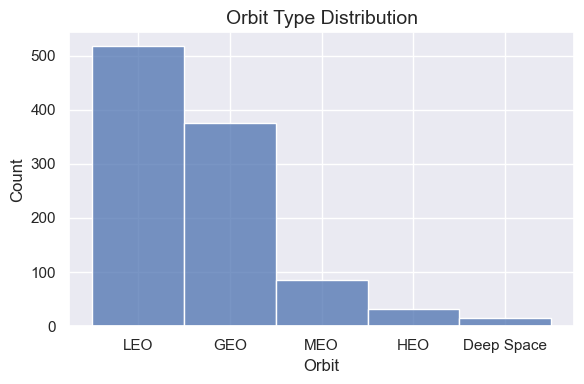

In [8]:
sns.set(font_scale=1.0) 
fig,ax = plt.subplots(figsize=(6,4))
sns.histplot(data=df,x='Orbit',ax=ax)
ax.set_title('Orbit Type Distribution',fontsize=14)
fig.tight_layout()
# fig.savefig('orbit_distribution.png',dpi=300)

Look at distributions of other data.

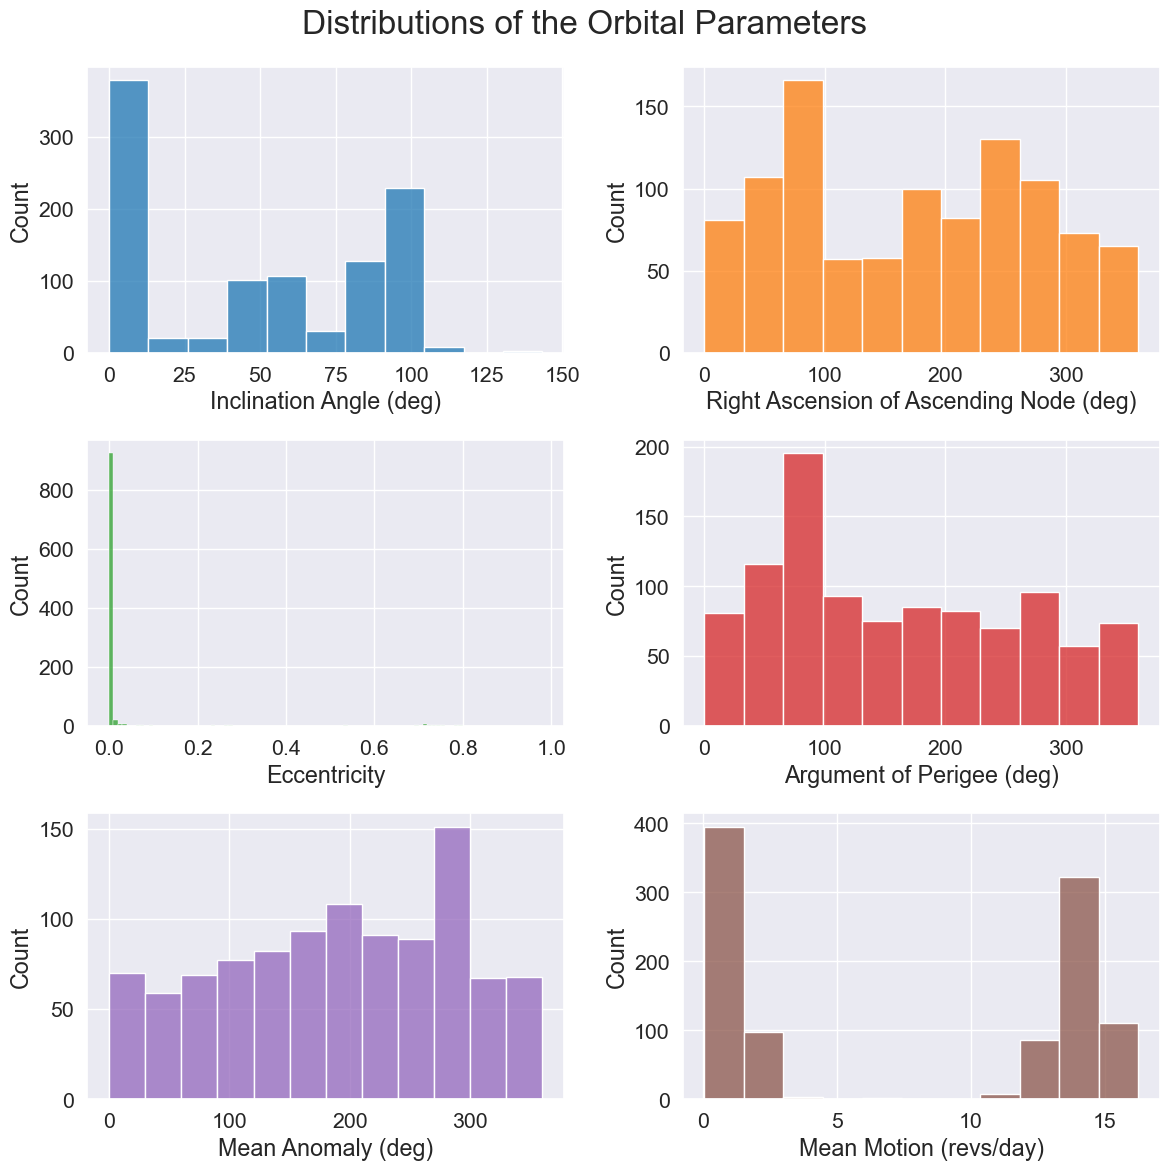

In [9]:
cmap = sns.color_palette('tab10')
sns.set(font_scale=1.4) 

fig, axs = plt.subplots(nrows=3,ncols=2,figsize=(12,12))
for idx, column in enumerate(df.drop(['Orbit Type','Orbit'],axis=1).columns):
    if column == 'Eccentricity':
        sns.histplot(data=df, x=column, ax=axs.flatten()[idx], color=cmap[idx], binwidth=.01)        
    else:
        sns.histplot(data=df, x=column, ax=axs.flatten()[idx], color=cmap[idx])
fig.suptitle('Distributions of the Orbital Parameters',fontsize=24)
fig.tight_layout()
# fig.savefig('variable_distributions.png',dpi=300)

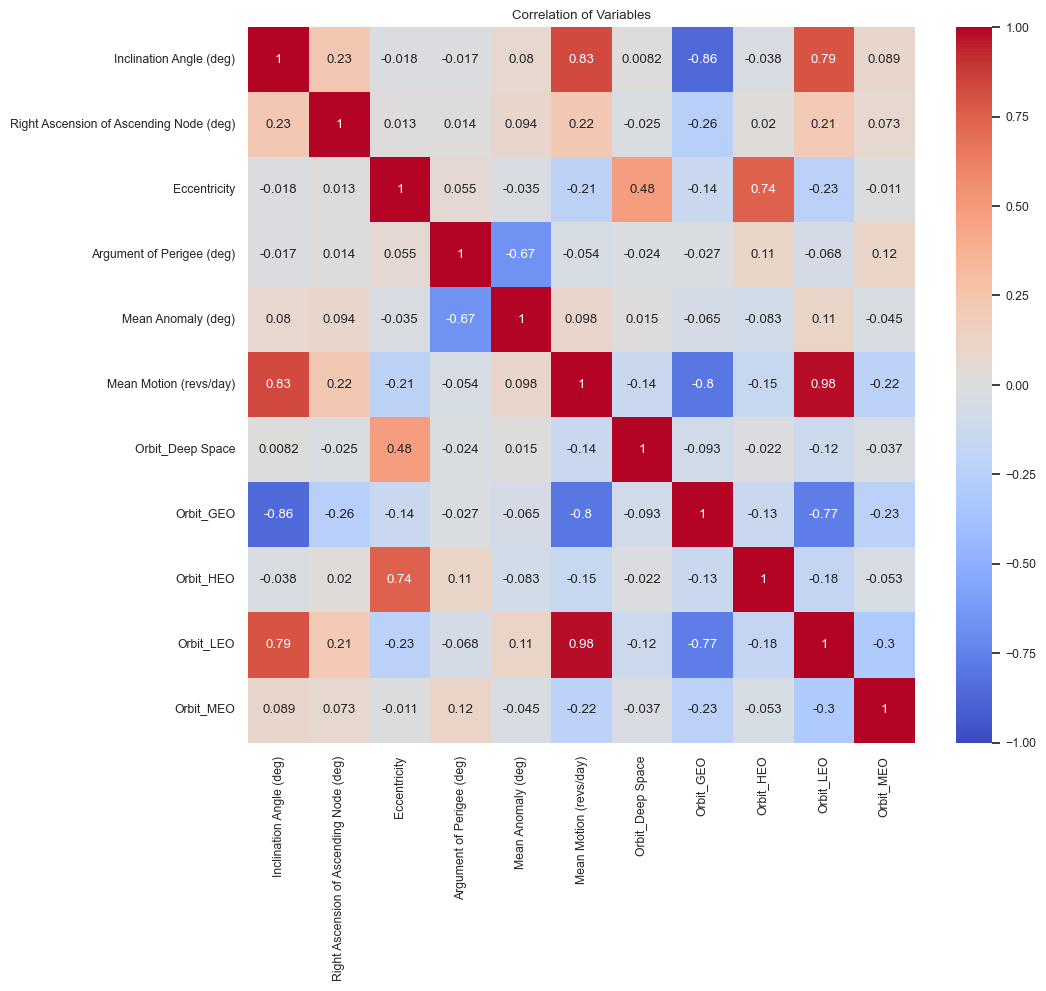

In [10]:
df_ohe = pd.get_dummies(df.drop('Orbit Type',axis=1), drop_first=False, dtype=int)
sns.set(font_scale=.8) 
fig, ax = plt.subplots(figsize=(11,10))
sns.heatmap(df_ohe.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
ax.set_title('Correlation of Variables')
fig.tight_layout()

C:\Users\elder\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


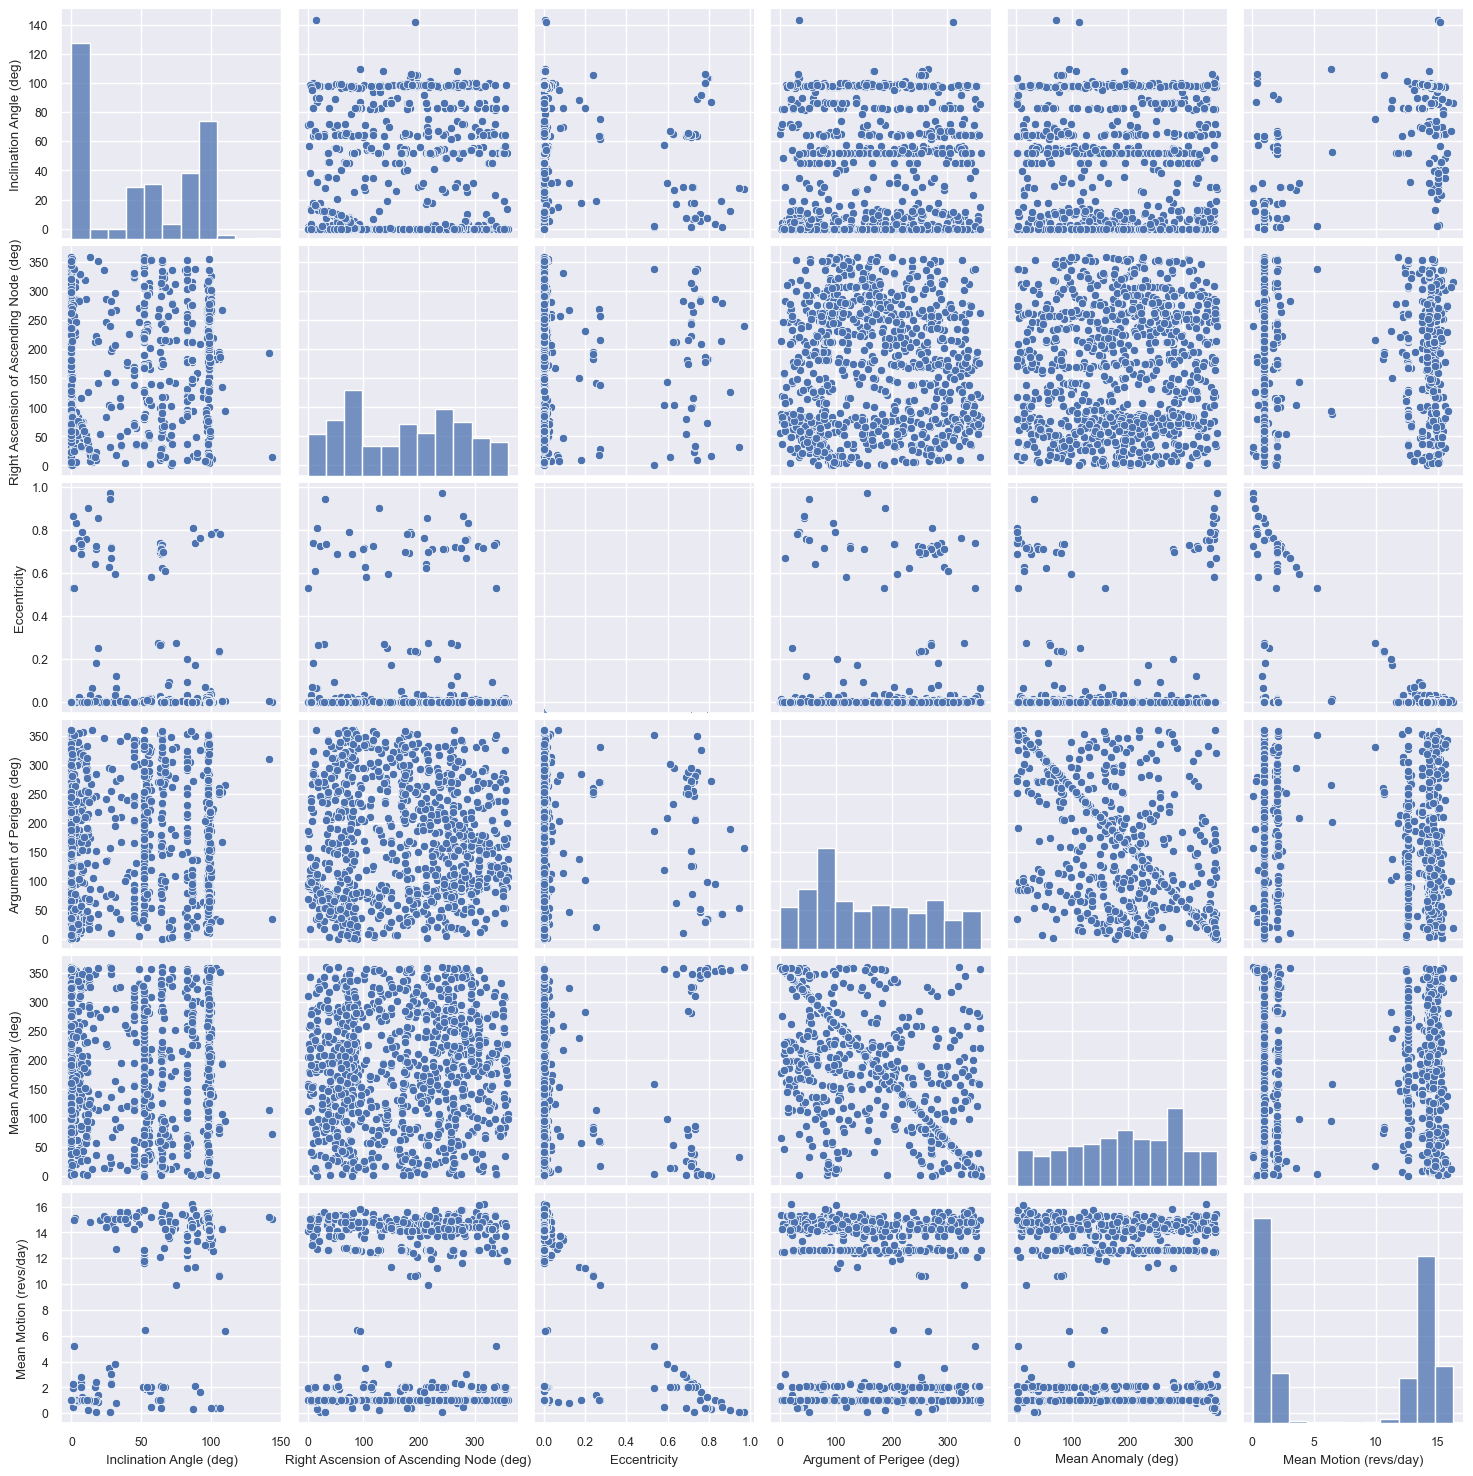

In [11]:
sns.pairplot(df.drop(['Orbit Type','Orbit'],axis=1))
plt.show()

A few of the scatter plots appear to have some groupings. Some of the most predominant are:
* Eccentricity and Mean Motion
* Eccentricity and Mean Anomaly
* Mean Motion and Inclination
* Mean Motion and Arg Perigee
* Mean Motion and Mean Anomaly

Look at several scatter plots with the Orbits identified

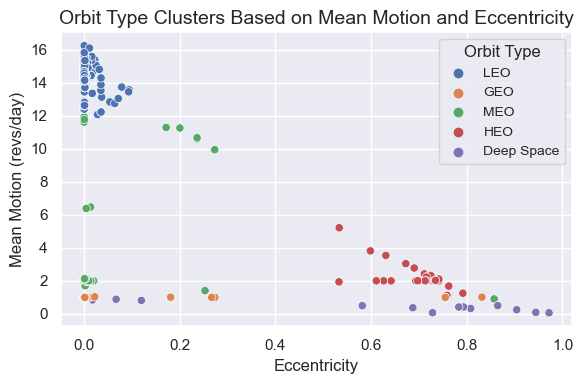

In [12]:
sns.set(font_scale=1.0) 
fig,ax = plt.subplots(figsize=(6,4))
sns.scatterplot(data=df, x='Eccentricity', y='Mean Motion (revs/day)', ax=ax, hue='Orbit')
ax.set_title('Orbit Type Clusters Based on Mean Motion and Eccentricity',fontsize=14)
ax.legend(fontsize=10,title='Orbit Type')
fig.tight_layout()
# fig.savefig('eccent_mean_motion.png',dpi=300)

## Split Data into Train/Validation/Test

In [192]:


df = df_og.drop('Orbit Type',axis=1).copy()
X = df.loc[:, df.columns != 'Orbit']
y = df.loc[:, df.columns == 'Orbit']

# Train and Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
# Split Training into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=49)

print('Train set shape\n',X_train.shape, y_train.shape)
print('Val set shape\n',X_val.shape, y_val.shape)
print('Test set shape\n',X_test.shape, y_test.shape)


Train set shape
 (614, 6) (614, 1)
Val set shape
 (205, 6) (205, 1)
Test set shape
 (205, 6) (205, 1)


---
# Modeling

### Metrics
Plan to use f1, precision, and recall as the primary metrics since the classes are unbalanced, and some classes are more important. The most important orbits to not misidentify are LEO, GEO and HEO. It would be better to mislabel MEOs as LEO or GEO rather than the otherway around. The Deep Space class is the least important.

In [14]:
orbit_labels = ['LEO', 'MEO', 'HEO', 'GEO','Deep Space']

In [142]:
# these are to view the results of validation or test data
def display_confusion_matrix(y_val,y_pred,labels=orbit_labels):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred,labels=labels),display_labels=labels)
    cmp.plot(ax=ax)
    ax.grid(False)
    fig.tight_layout()

    
def print_classification_report(y_val, y_pred, target_names=orbit_labels,digits=3):
    print(classification_report(y_val, y_pred,target_names=target_names,digits=digits))

## Trivial Model
### Always Predict Majority Class (LEO)

C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LEO      0.000     0.000     0.000         5
         MEO      0.000     0.000     0.000        71
         HEO      0.000     0.000     0.000         6
         GEO      0.488     1.000     0.656       100
  Deep Space      0.000     0.000     0.000        23

    accuracy                          0.488       205
   macro avg      0.098     0.200     0.131       205
weighted avg      0.238     0.488     0.320       205



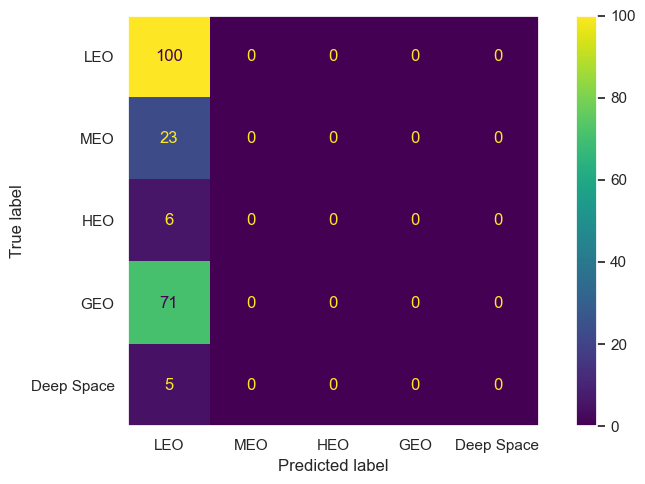

In [143]:
y_pred_maj = ['LEO']*len(y_val)

display_confusion_matrix(y_val,y_pred_maj)
print_classification_report(y_val,y_pred_maj)

### Randomly Predict Class

              precision    recall  f1-score   support

         LEO      0.000     0.000     0.000         5
         MEO      0.319     0.211     0.254        71
         HEO      0.000     0.000     0.000         6
         GEO      0.439     0.180     0.255       100
  Deep Space      0.158     0.261     0.197        23

    accuracy                          0.190       205
   macro avg      0.183     0.130     0.141       205
weighted avg      0.342     0.190     0.235       205



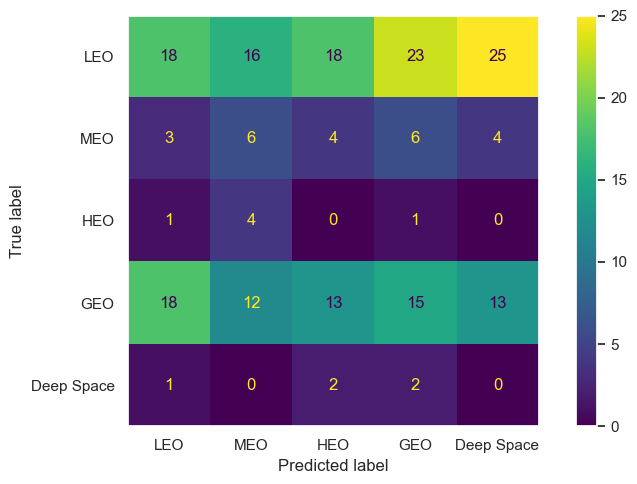

In [144]:
y_pred_rand = np.random.choice(df['Orbit'].unique(),replace=True,size=len(y_val))

display_confusion_matrix(y_val,y_pred_rand)
print_classification_report(y_val,y_pred_rand)

## Classical Modeling

### Logistic Regression


              precision    recall  f1-score   support

         LEO      1.000     0.400     0.571         5
         MEO      0.947     1.000     0.973        71
         HEO      1.000     0.833     0.909         6
         GEO      0.990     1.000     0.995       100
  Deep Space      1.000     0.957     0.978        23

    accuracy                          0.976       205
   macro avg      0.987     0.838     0.885       205
weighted avg      0.977     0.976     0.972       205



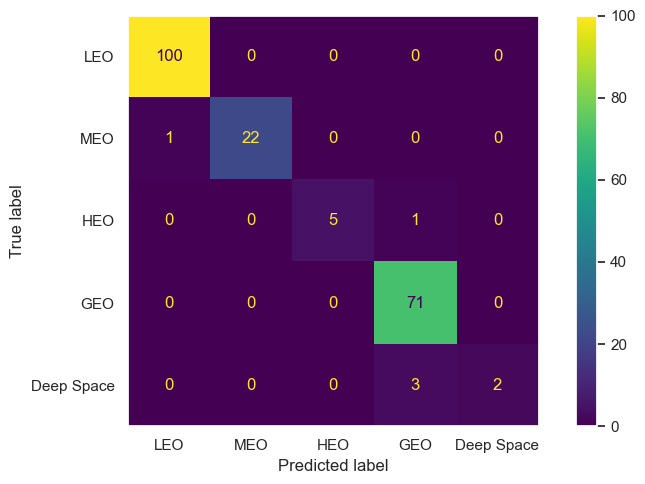

In [147]:
clf_log = LogisticRegression(max_iter=10000).fit(X_train,y_train.values.ravel())

y_pred_log = clf_log.predict(X_val)

display_confusion_matrix(y_val,y_pred_log)
print_classification_report(y_val,y_pred_log)

#### Scale data 

              precision    recall  f1-score   support

         LEO      0.667     0.400     0.500         5
         MEO      0.986     1.000     0.993        71
         HEO      0.714     0.833     0.769         6
         GEO      0.980     1.000     0.990       100
  Deep Space      1.000     0.913     0.955        23

    accuracy                          0.971       205
   macro avg      0.869     0.829     0.841       205
weighted avg      0.969     0.971     0.969       205



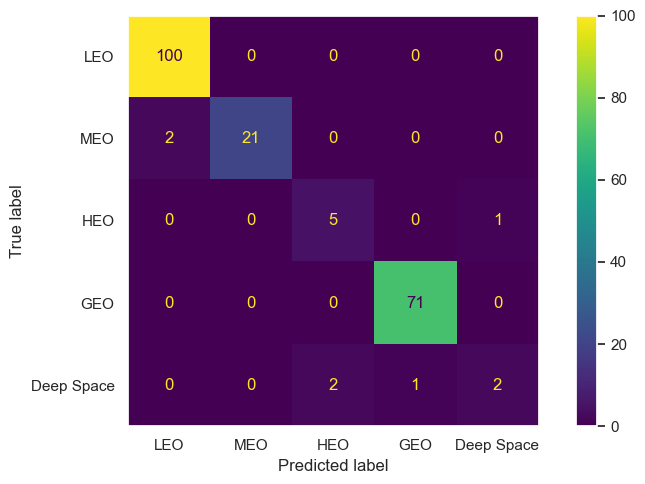

In [148]:
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_val_trans = scaler.transform(X_val)

clf_log_scl = LogisticRegression(max_iter=10000).fit(X_train_trans,y_train.values.ravel())
y_pred_log_scl = clf_log_scl.predict(X_val_trans)

display_confusion_matrix(y_val,y_pred_log_scl)
print_classification_report(y_val,y_pred_log_scl)

Slight decrease in performance with scaled input variables

C:\Users\elder\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


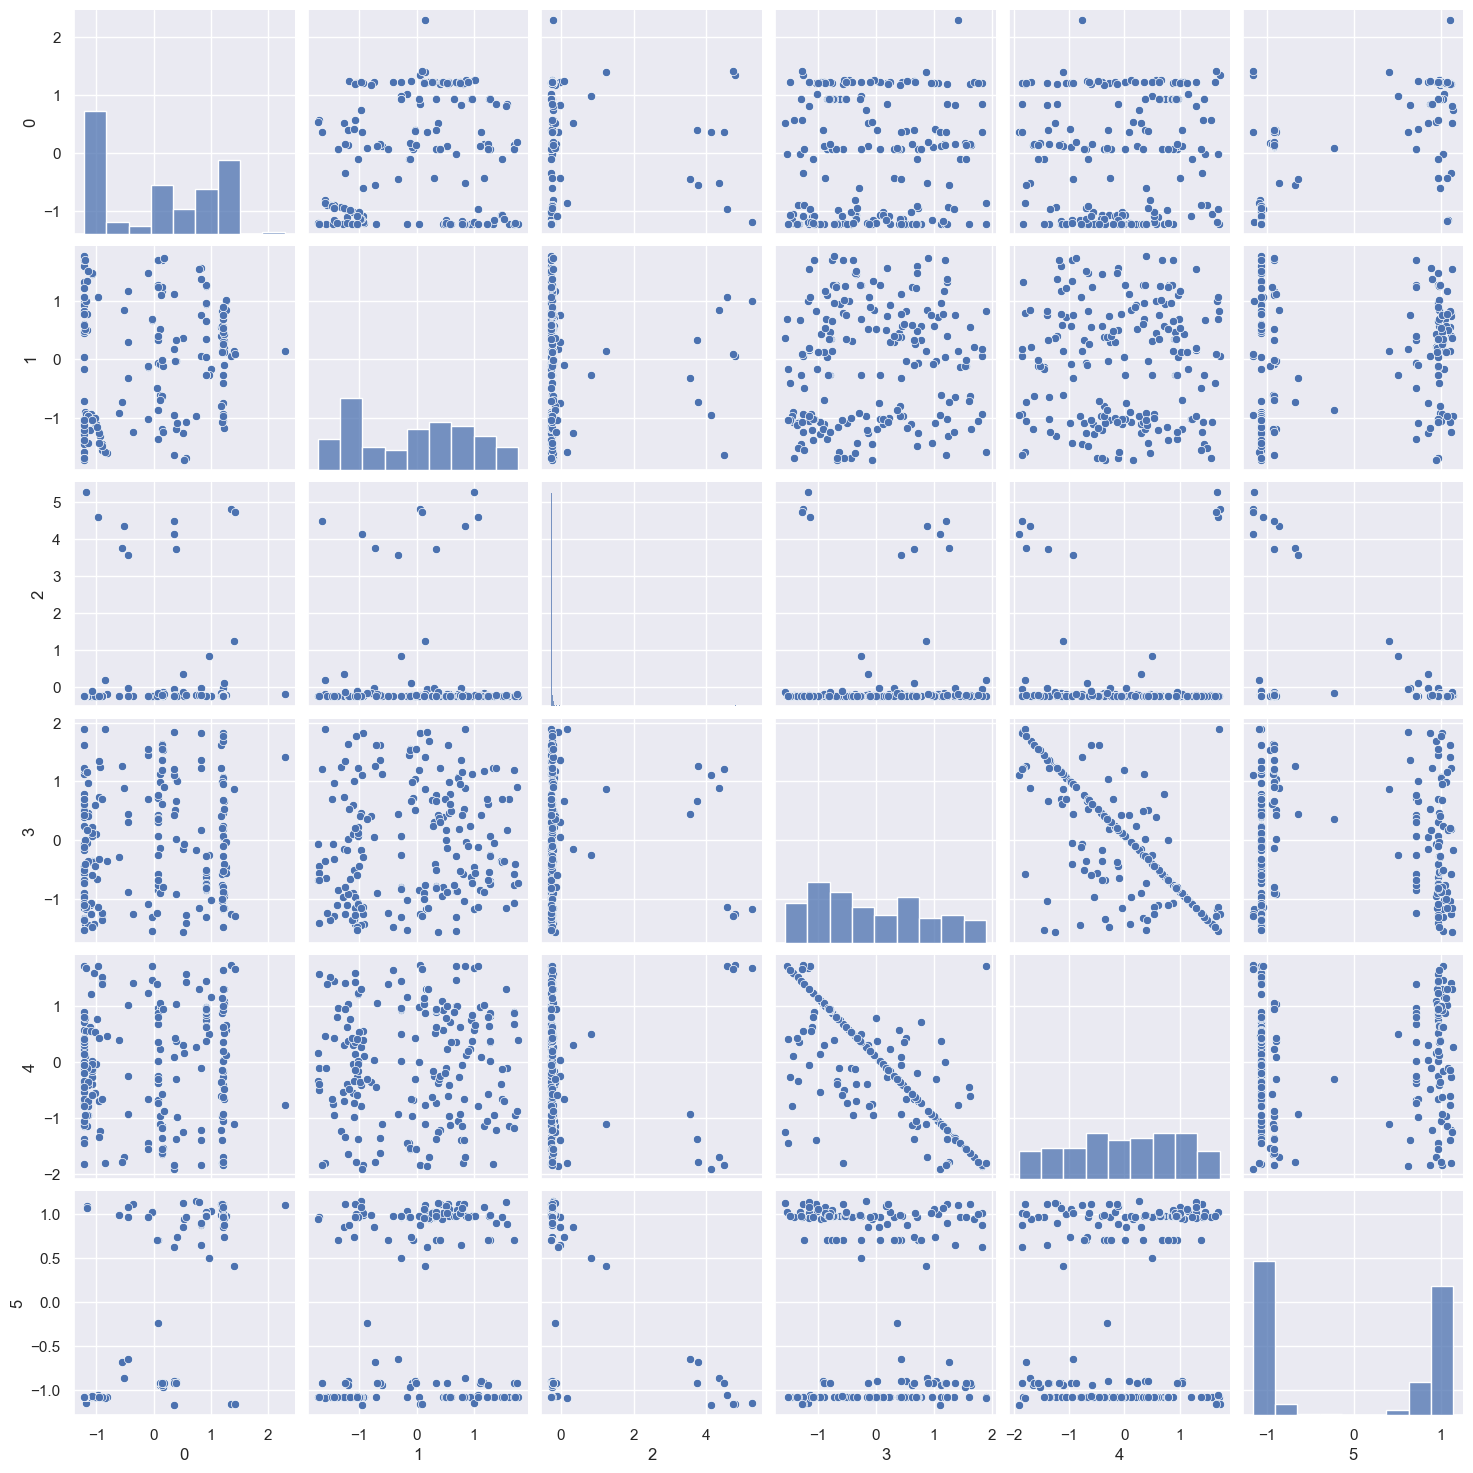

In [150]:
sns.pairplot(pd.DataFrame(X_val_trans))
plt.show()

C:\Users\elder\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\elder\AppData\Local\Temp\ipykernel_67988\2051625880.py:2: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


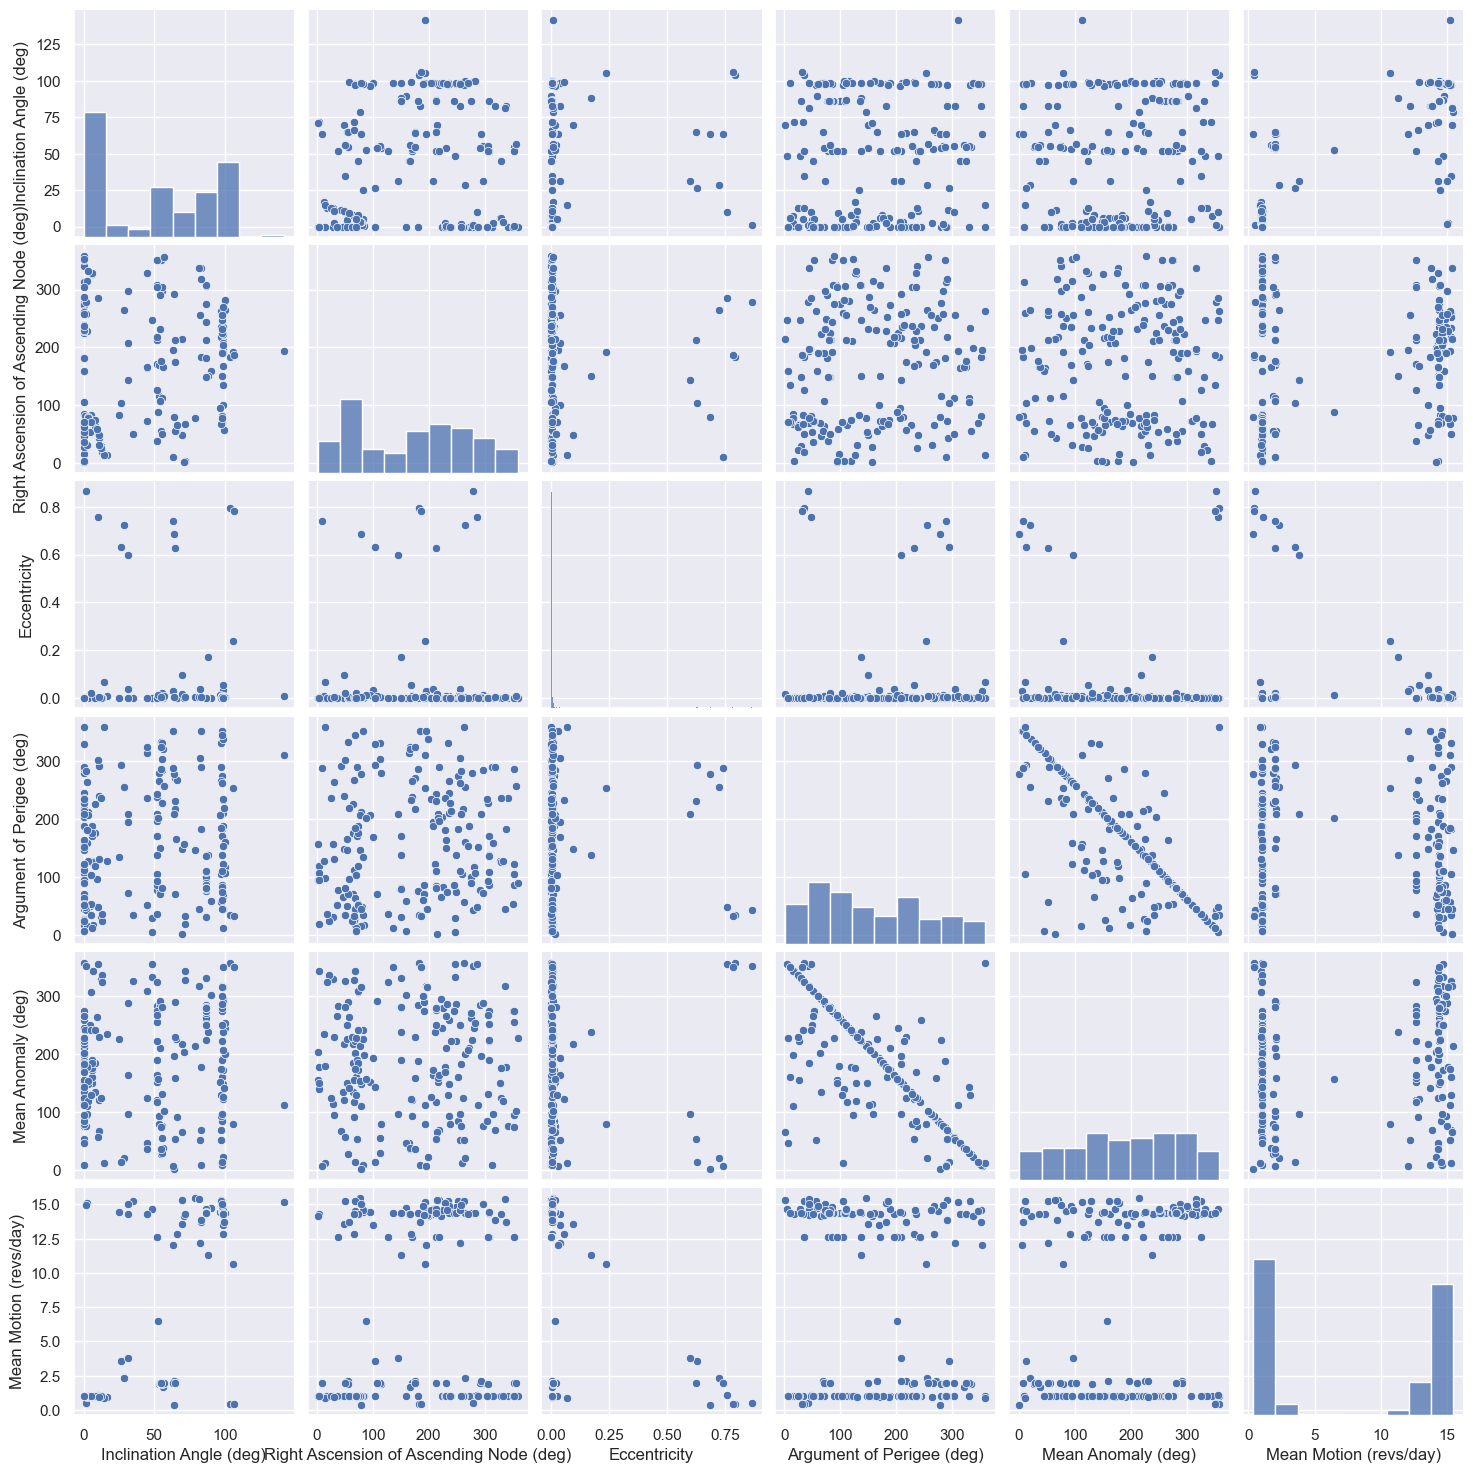

In [155]:
sns.pairplot(X_val)
fig.tight_layout()

### Decision Tree

In [131]:
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

              precision    recall  f1-score   support

         LEO      1.000     1.000     1.000         5
         MEO      0.986     1.000     0.993        71
         HEO      1.000     0.833     0.909         6
         GEO      1.000     0.990     0.995       100
  Deep Space      0.958     1.000     0.979        23

    accuracy                          0.990       205
   macro avg      0.989     0.965     0.975       205
weighted avg      0.991     0.990     0.990       205



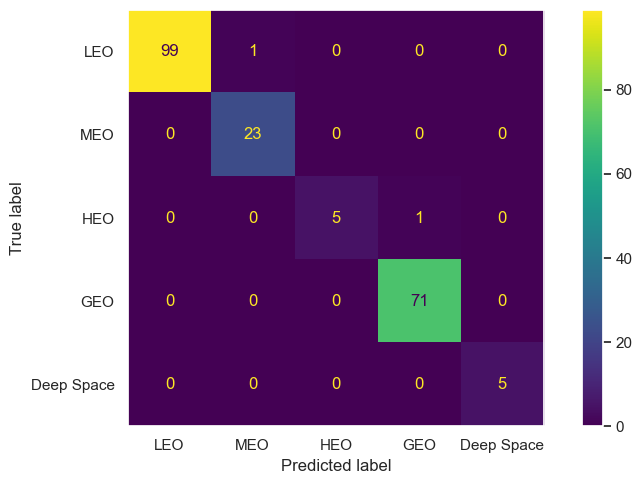

In [159]:
clf_dt = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_val)

display_confusion_matrix(y_val,y_pred_dt)
print_classification_report(y_val,y_pred_dt)

View Decision Tree

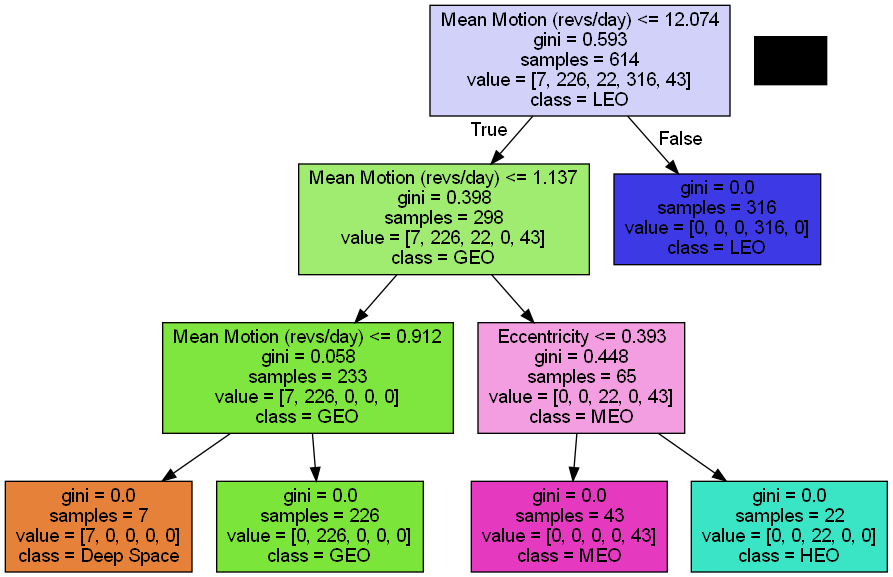

In [160]:
d_tree, = print_tree(clf_dt, features=clf_dt.feature_names_in_,class_names=clf_dt.classes_)
Image(d_tree.create_png())

Only two features were used: Mean Motion and Eccentricity

Check scaled data again

              precision    recall  f1-score   support

         LEO      1.000     1.000     1.000         5
         MEO      0.986     1.000     0.993        71
         HEO      1.000     0.833     0.909         6
         GEO      1.000     0.990     0.995       100
  Deep Space      0.958     1.000     0.979        23

    accuracy                          0.990       205
   macro avg      0.989     0.965     0.975       205
weighted avg      0.991     0.990     0.990       205



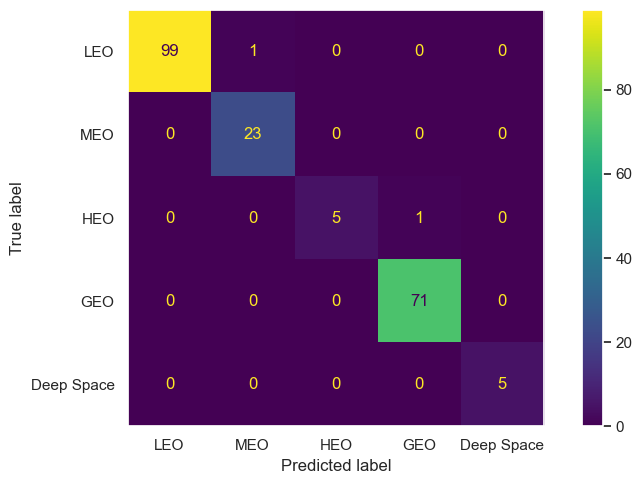

In [162]:
clf_dt_scl = DecisionTreeClassifier().fit(X_train, y_train)
y_pred_dt_scl = clf_dt_scl.predict(X_val)

display_confusion_matrix(y_val,y_pred_dt_scl)
print_classification_report(y_val,y_pred_dt_scl)

Same results with scaling as without

#### Reduce Features to Confirm

              precision    recall  f1-score   support

         LEO      1.000     1.000     1.000         5
         MEO      0.986     1.000     0.993        71
         HEO      1.000     0.833     0.909         6
         GEO      1.000     0.990     0.995       100
  Deep Space      0.958     1.000     0.979        23

    accuracy                          0.990       205
   macro avg      0.989     0.965     0.975       205
weighted avg      0.991     0.990     0.990       205



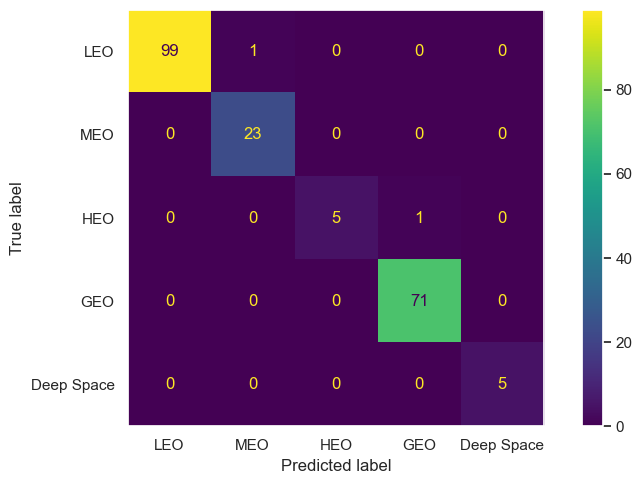

In [161]:
cols_to_drop = ['Inclination Angle (deg)','Right Ascension of Ascending Node (deg)','Argument of Perigee (deg)','Mean Anomaly (deg)']

clf_dt_simple = DecisionTreeClassifier().fit(X_train.drop(columns=cols_to_drop), y_train)
y_pred_dt_simple = clf_dt_simple.predict(X_val.drop(columns=cols_to_drop))

display_confusion_matrix(y_val,y_pred_dt_simple)
print_classification_report(y_val,y_pred_dt_simple)

Lets see which one performs better on its own.

##### Mean Motion as only feature

              precision    recall  f1-score   support

         LEO      1.000     1.000     1.000         5
         MEO      0.986     1.000     0.993        71
         HEO      0.833     0.833     0.833         6
         GEO      1.000     0.990     0.995       100
  Deep Space      0.957     0.957     0.957        23

    accuracy                          0.985       205
   macro avg      0.955     0.956     0.956       205
weighted avg      0.985     0.985     0.985       205



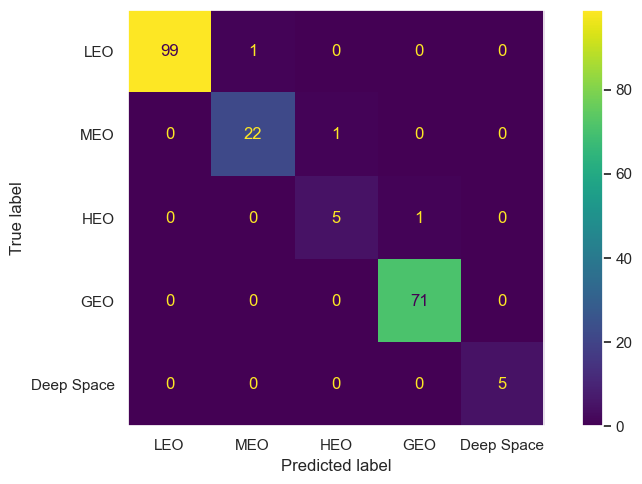

In [164]:
clf_dt_meanmotion = DecisionTreeClassifier().fit(X_train[['Mean Motion (revs/day)']], y_train)
y_pred_dt_meanmotion = clf_dt_meanmotion.predict(X_val[['Mean Motion (revs/day)']])

display_confusion_matrix(y_val,y_pred_dt_meanmotion)
print_classification_report(y_val,y_pred_dt_meanmotion)


Model performance is good is only slightly worse with just one feature (Mean Motion)

##### Eccentricity as only feature

              precision    recall  f1-score   support

         LEO      1.000     0.200     0.333         5
         MEO      0.500     0.549     0.523        71
         HEO      0.714     0.833     0.769         6
         GEO      0.547     0.580     0.563       100
  Deep Space      0.308     0.174     0.222        23

    accuracy                          0.522       205
   macro avg      0.614     0.467     0.482       205
weighted avg      0.520     0.522     0.512       205



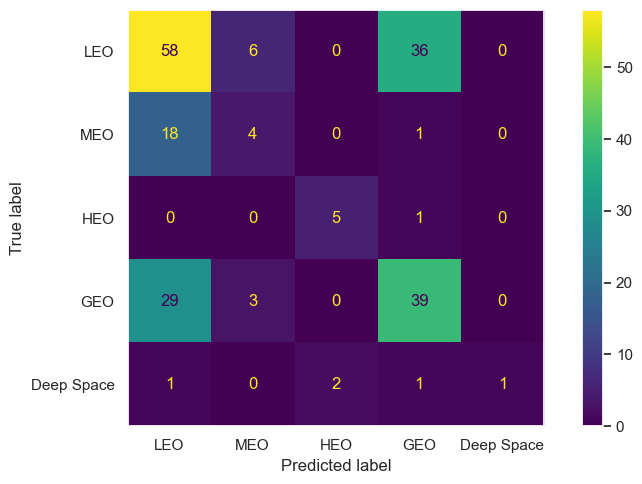

In [166]:
clf_dt_eccentricity = DecisionTreeClassifier().fit(X_train[['Eccentricity']], y_train)
y_pred_dt_eccentricity = clf_dt_eccentricity.predict(X_val[['Eccentricity']])

display_confusion_matrix(y_val,y_pred_dt_eccentricity)
print_classification_report(y_val,y_pred_dt_eccentricity)


Model performance is significantly worse with just Eccentricity as the feature.

In [46]:
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, verbose=1, cv=3)

print(grid_search_cv.fit(X_train, y_train))

Fitting 3 folds for each of 294 candidates, totalling 882 fits
GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]},
             verbose=1)


In [47]:
print(grid_search_cv.best_estimator_)

DecisionTreeClassifier(max_leaf_nodes=5)


### Linear Discriminant Analysis (LDA)

              precision    recall  f1-score   support

         LEO      1.000     0.400     0.571         5
         MEO      0.986     1.000     0.993        71
         HEO      0.750     1.000     0.857         6
         GEO      0.980     1.000     0.990       100
  Deep Space      1.000     0.913     0.955        23

    accuracy                          0.976       205
   macro avg      0.943     0.863     0.873       205
weighted avg      0.978     0.976     0.973       205



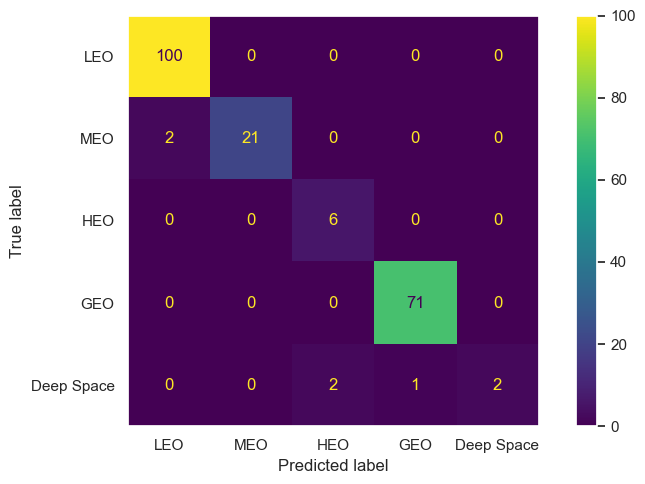

In [167]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf_lda = LinearDiscriminantAnalysis().fit(X_train,y_train.values.ravel())
y_pred_lda = clf_lda.predict(X_val)

display_confusion_matrix(y_val,y_pred_lda)
print_classification_report(y_val,y_pred_lda)


### Quadratic Discriminant Analysis (QDA)

              precision    recall  f1-score   support

         LEO      0.667     0.400     0.500         5
         MEO      1.000     0.958     0.978        71
         HEO      0.750     1.000     0.857         6
         GEO      1.000     0.980     0.990       100
  Deep Space      0.821     1.000     0.902        23

    accuracy                          0.961       205
   macro avg      0.848     0.868     0.845       205
weighted avg      0.965     0.961     0.960       205



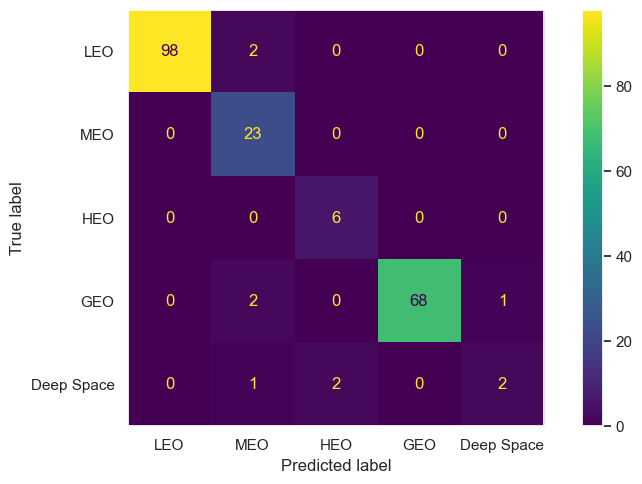

In [170]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf_qda = QuadraticDiscriminantAnalysis().fit(X_train,y_train.values.ravel())
y_pred_qda = clf_qda.predict(X_val)

display_confusion_matrix(y_val,y_pred_qda)
print_classification_report(y_val,y_pred_qda)

Try other methods with just Eccentricity and Mean Motion



Log

              precision    recall  f1-score   support

         LEO      1.000     0.400     0.571         5
         MEO      0.947     1.000     0.973        71
         HEO      1.000     0.833     0.909         6
         GEO      0.990     1.000     0.995       100
  Deep Space      1.000     0.957     0.978        23

    accuracy                          0.976       205
   macro avg      0.987     0.838     0.885       205
weighted avg      0.977     0.976     0.972       205


LDA

              precision    recall  f1-score   support

         LEO      1.000     0.400     0.571         5
         MEO      0.986     1.000     0.993        71
         HEO      0.750     1.000     0.857         6
         GEO      0.980     1.000     0.990       100
  Deep Space      1.000     0.913     0.955        23

    accuracy                          0.976       205
   macro avg      0.943     0.863     0.873       205
weighted avg      0.978     0.976     0.973       205


QDA

    

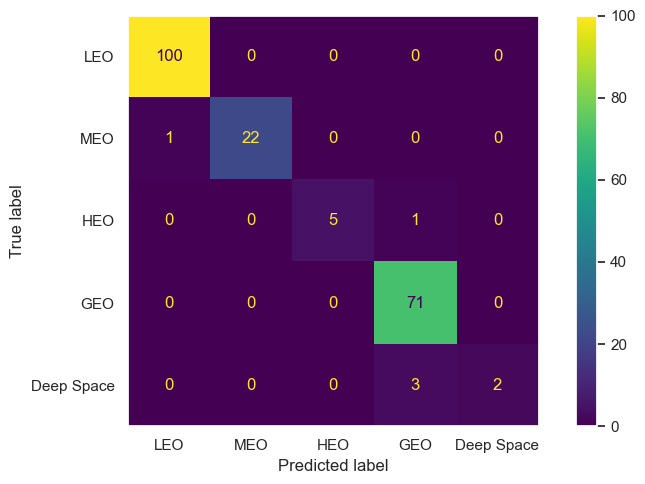

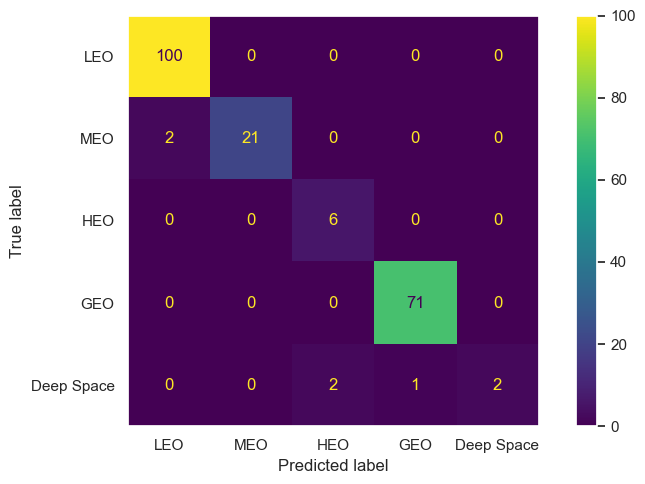

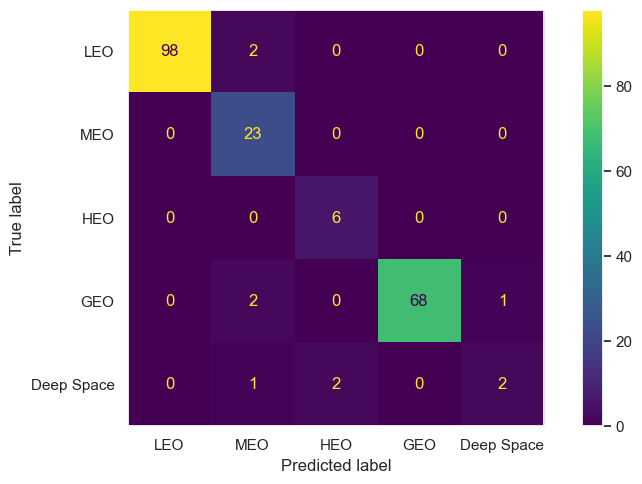

In [171]:

# Log
model = LogisticRegression(max_iter=10000).fit(X_train,y_train.values.ravel())
y_pred = model.predict(X_val)
print('\nLog\n')
display_confusion_matrix(y_val,y_pred)
print_classification_report(y_val,y_pred)

# LDA
model = LinearDiscriminantAnalysis().fit(X_train,y_train.values.ravel())
y_pred = model.predict(X_val)
print('\nLDA\n')
display_confusion_matrix(y_val,y_pred)
print_classification_report(y_val,y_pred)
# QDA
model = QuadraticDiscriminantAnalysis().fit(X_train,y_train.values.ravel())
y_pred = model.predict(X_val)
print('\nQDA\n')
display_confusion_matrix(y_val,y_pred)
print_classification_report(y_val,y_pred)

Non of the other models performed as well with just the two features.

## Neural Network

1. Justify your selection of optimization algorithm, loss function and regularization technique, based on the type of problem you are modeling (see concept map on slide 8 of 6B Optimization.pptx).
2. Document how you monitor to prevent overfitting, such as a train/validate split, or cross-validation. Justify your selection, based on your number of datapoints and number of input variables.
3. Perform a hyperparameter sweep on neurons per layer, number of layers and 2 other hyperparameters. Select the model with the best performance.  
4. Investigate how 1 regularization technique affects your modeling, and document the results.
5. Select a “best” model and create a figure that shows the NN did not overfit while training (train/test metric vs epochs).
6. Create a table (similar to part 7d) that summarizes the performance of part 8c/8d NN 3 variations. 

1.  
    * Optimization algorithm: adam or Stochastic Gradient Descent (shallow networks)
    * Loss Function: Cross-entropy (3+ classification)
    * Regularization Technique:   

2. Cross-validation

In [189]:
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [215]:
# create dummy variables for orbits
encoder = LabelEncoder().fit(y_trainval.values.ravel())
y_trainval_encoded = encoder.transform(y_trainval.values.ravel())
y_trainval_dummy = np_utils.to_categorical(y_trainval_encoded)

X_trainval_array = np.array(X_trainval)

In [224]:
model = Sequential()
model.add(Dense(12,input_dim=X_trainval.shape[1],activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(len(orbit_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X_trainval_array,y_trainval_dummy,validation_split=0.25,epochs=100)
_,accuracy = model.evaluate(X_trainval_array,y_trainval_dummy)


Epoch 1/100
20/20 [==============================] - 1s 15ms/step - loss: 48.8658 - accuracy: 0.0651 - val_loss: 31.9352 - val_accuracy: 0.1317
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 21.9626 - accuracy: 0.1906 - val_loss: 12.9934 - val_accuracy: 0.3463
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 11.1050 - accuracy: 0.4593 - val_loss: 8.8635 - val_accuracy: 0.5024
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 7.8962 - accuracy: 0.5147 - val_loss: 6.4764 - val_accuracy: 0.5220
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 5.5616 - accuracy: 0.5358 - val_loss: 4.7574 - val_accuracy: 0.5268
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 4.0417 - accuracy: 0.5651 - val_loss: 3.6145 - val_accuracy: 0.5317
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 3.0290 - accuracy: 0.5928 - val_loss: 2.8697 - val_accuracy: 0.6098
Epoch 8

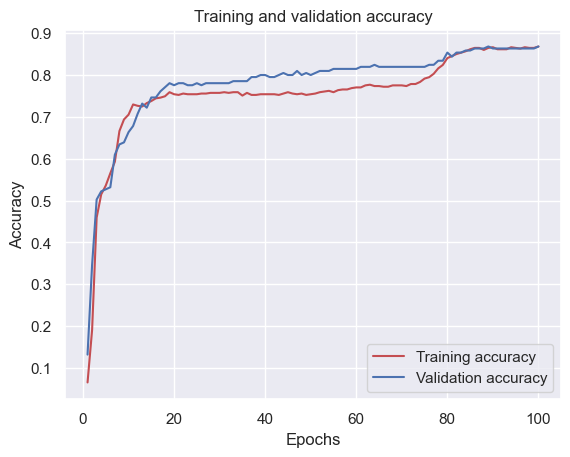

In [226]:
history_dict = history.history

# learning curve
# accuracy
# acc = history_dict['accuracy']
acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
val_acc = history_dict['val_accuracy']

# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "r" is for "solid red line"
plt.plot(epochs, acc, 'r', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 [==============================] - 0s 3ms/step
[1.7223451e-02 9.7078317e-01 3.0999668e-03 8.8863575e-04 8.0048302e-03]
1.0000001
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.934     1.000     0.966        71
           2      0.500     0.167     0.250         6
           3      0.778     0.980     0.867       100
           4      1.000     0.043     0.083        23

    accuracy                          0.834       205
   macro avg      0.642     0.438     0.433       205
weighted avg      0.830     0.834     0.774       205



C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


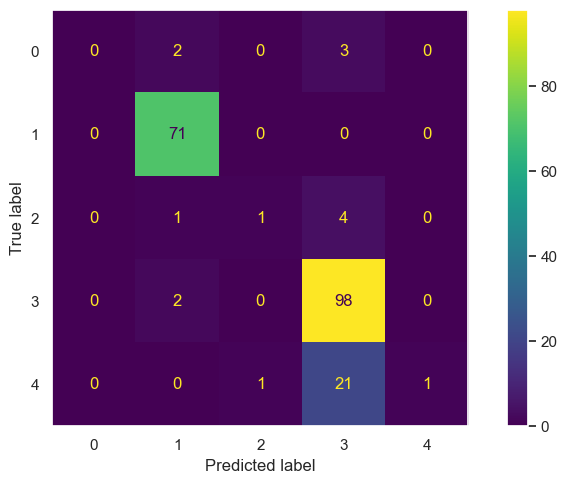

In [244]:
preds = model.predict(X_val) # see how the model did!
print(preds[0]) # i'm spreading that prediction across three nodes and they sum to 1
print(np.sum(preds[0])) # sum it up! Should be 1

y_val_encoded = encoder.transform(y_val.values.ravel())
y_pred_NN_encoded = preds.argmax(axis=1)

display_confusion_matrix(y_val_encoded,y_pred_NN_encoded,labels=None)
print_classification_report(y_val_encoded,y_pred_NN_encoded,target_names=None)



---
# Test on Space Track data

In [175]:
# These functions were copied or modified from https://github.com/Elucidation/OrbitalElements/blob/master/orbit.py
# They validate and parse the tles

def splitElem(tle):
    "Splits a two line element set into title and it's two lines with stripped lines"
    return map(lambda x: x.strip(), tle.split('\n'))

def checkValid(tle):
    "Checks with checksum to make sure element is valid"
    title, line1, line2 =  splitElem(tle)

    return line1[0] == '1' and line2[0] == '2' and \
           line1[2:7] == line2[2:7] and \
           int(line1[-1]) == doChecksum(line1) and int(line2[-1]) == doChecksum(line2)

def doChecksum(line):
    """The checksums for each line are calculated by adding the all numerical digits on that line, including the 
       line number. One is added to the checksum for each negative sign (-) on that line. All other non-digit 
       characters are ignored.
       @note this excludes last char for the checksum thats already there."""
    return sum(map(int, filter(lambda c: c >= '0' and c <= '9', line[:-1].replace('-','1')))) % 10


def parse_tle(tle):
    satellite = {}
    title, line1, line2 =  splitElem(tle)
    satellite['Name'] = title.strip()[2:]
    satellite['SSC Number'] = line1[2:7]
    satellite['Inclination Angle (deg)'] = float(line2[8:16])
    satellite['Right Ascension of Ascending Node (deg)']  = float(line2[17:25])
    satellite['Eccentricity'] = float(line2[26:33]) * 0.0000001
    satellite['Argument of Perigee (deg)'] = float(line2[34:42])
    satellite['Mean Anomaly (deg)'] = float(line2[43:51])
    satellite['Mean Motion (revs/day)'] = float(line2[52:63])
    return satellite



def build_satellite_df_from_tle_file(filename):
    '''
    Builds a pandas df from a TLE text file.
    '''
    # Get all lines from the TLE file
    with open(filename, 'r') as f:
        lines = f.readlines()
    # Separate the TLEs as lines in a list
    elem = ""
    tles = []
    for line in lines:
        elem += line
        if (line[0] == '2'):
            tle = elem.strip()
            if checkValid(tle):
                tles.append(tle)
            elem = ""
    # parse the TLEs and create the dataframe
    satellites = [parse_tle(tle) for tle in tles]
    return pd.DataFrame(satellites)



C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\elder\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LEO      0.000     0.000     0.000         0
         MEO      0.994     1.000     0.997      1016
         HEO      1.000     0.767     0.868       202
         GEO      1.000     0.996     0.998      9468
  Deep Space      0.830     1.000     0.907       253

    accuracy                          0.992     10939
   macro avg      0.765     0.753     0.754     10939
weighted avg      0.996     0.992     0.993     10939



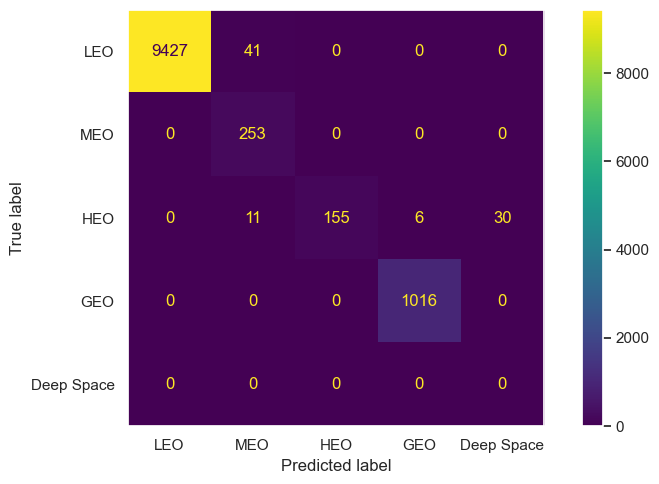

In [179]:
# the varios catalogs were downloaded individually from space-track.org so that orbit labels could be added
heo_df = build_satellite_df_from_tle_file('tle_heo.txt')
heo_df['Orbit'] = 'HEO'
meo_df = build_satellite_df_from_tle_file('tle_meo.txt')
meo_df['Orbit'] = 'MEO'
leo_df = build_satellite_df_from_tle_file('tle_leo.txt')
leo_df['Orbit'] = 'LEO'
geo_df = build_satellite_df_from_tle_file('tle_geo.txt')
geo_df['Orbit'] = 'GEO'


# combine all the orbit dfs together
df_lgmh = pd.concat([leo_df,geo_df,meo_df,heo_df])

# get prediction and display results
y_pred_sattrack = clf_dt.predict(df_lgmh.drop(columns=['Name','SSC Number','Orbit']))
y_test_sattrack = df_lgmh['Orbit']

display_confusion_matrix(y_test_sattrack,y_pred_sattrack)
print_classification_report(y_test_sattrack,y_pred_sattrack)

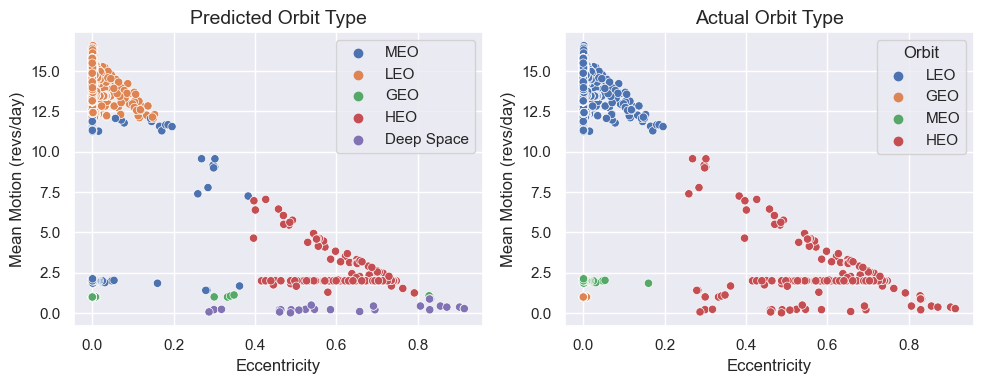

In [180]:
fig,axs = plt.subplots(nrows=1,ncols=2, figsize=(10,4))
sns.scatterplot(data=df_lgmh, x='Eccentricity', y='Mean Motion (revs/day)', ax=axs[0], hue=y_pred_sattrack)
axs[0].set_title('Predicted Orbit Type',fontsize=14)

sns.scatterplot(data=df_lgmh, x='Eccentricity', y='Mean Motion (revs/day)', ax=axs[1], hue='Orbit')
axs[1].set_title('Actual Orbit Type',fontsize=14)
fig.tight_layout()
